# Select and save oceanic regions from shapefile

In [1]:
import geopandas as gpd
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import sys
import os
import seaborn as sns
from scipy.stats import linregress
from scipy import stats
from dask import delayed
import imageio
#from joblib import Parallel, delayed
import matplotlib.dates as mdates
import intake
from DV8_functions_1 import *
import geopandas as gpd
import regionmask
import rasterio
#DV8_functions(1) packages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FFMpegWriter
from matplotlib import animation, rc
from IPython.display import HTML
#my functions:


import matplotlib.colors as mcolors

from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
import dask
from dask.distributed import Client, LocalCluster
import bokeh
import subprocess
import re

import warnings
#warnings.filterwarnings('ignore')


In [2]:


dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
cluster = LocalCluster(n_workers=32,threads_per_worker=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/b382616/levante-spawner-advanced//proxy/8787/status,
Dashboard: /user/b382616/levante-spawner-advanced//proxy/8787/status,Workers: 32
Total threads: 32,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42439,Workers: 32
Dashboard: /user/b382616/levante-spawner-advanced//proxy/8787/status,Total threads: 32
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:39701,Total threads: 1
Dashboard: /user/b382616/levante-spawner-advanced//proxy/41759/status,Memory: 7.81 GiB
Nanny: tcp://127.0.0.1:41105,


In [3]:
# Path to your shapefile (.shp)
shapefile = "goas_v01.shp"

# Load the shapefile
oceans = gpd.read_file(shapefile)




Flanders Marine Institute (2021). Global Oceans and Seas, version 1. Available online at https://www.marineregions.org/. https://doi.org/10.14284/542.

In [3]:
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_shift_hob_maxanom5.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
ds = xr.open_zarr(str(file_name), chunks=chunks)
#ds = ds.sel(lat=slice(None, 70))
ossta=ds['dat_anomaly']


In [4]:
import geopandas as gpd
import xarray as xr
from pathlib import Path
from getpass import getuser

# Path to save masks
save_path = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'DV8'
save_path.mkdir(parents=True, exist_ok=True)
mask_file = save_path / "region_masks.zarr"

# -----------------------------
# Check if masks already exist
if mask_file.exists():
    print("Loading existing masks...")
    region_masks_ds = xr.open_zarr(str(mask_file))
    # Convert to dictionary of DataArrays
    region_masks = {var: region_masks_ds[var] for var in region_masks_ds.data_vars}
else:
    print("Creating masks...")
    region_masks = {}

    # Example SST slice
    example_sst = ossta.isel(time=0)
    # Assign CRS to the DataArray if missing
    example_sst = example_sst.rio.write_crs("EPSG:4326")


    shapefile = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'DV8' / 'goas_v01.shp'

    # Load shapefile
    oceans = gpd.read_file(shapefile).to_crs("EPSG:4326")

    # ----- Southern Ocean -----
    southern_oceans = oceans[oceans["name"].str.contains("South") | (oceans["name"]=="Indian Ocean")]
    mask_southern = example_sst.rio.clip(southern_oceans.geometry, southern_oceans.crs, drop=False)
    mask_southern_bool = ~xr.ufuncs.isnan(mask_southern)
    region_masks["Southern_Ocean"] = mask_southern_bool & (mask_southern_bool.lat <= -40)

    # ----- Equatorial masks per ocean -----
    lat_min, lat_max = -10, 10
    equatorial_oceans = ["Pacific", "Atlantic", "Indian"]
    for ocean_name in equatorial_oceans:
        gdf = oceans[oceans["name"].str.contains(ocean_name)]
        if gdf.empty:
            continue
        mask_da = example_sst.rio.clip(gdf.geometry, gdf.crs, drop=False)
        mask_bool = ~xr.ufuncs.isnan(mask_da)
        region_masks[f"{ocean_name}_Equatorial"] = mask_bool & (mask_bool.lat >= lat_min) & (mask_bool.lat <= lat_max)

    # ----- Mid/High latitude masks -----
    lat_bands = {
        "MidSouth": (-40, -10),
        "MidNorth": (10, 30),
        "Northern": (30, 70)
    }
    oceans_to_mask = ["North Pacific Ocean", "South Pacific Ocean",
                      "North Atlantic Ocean", "South Atlantic Ocean",
                      "Indian Ocean"]
    for ocean in oceans_to_mask:
        ocean_gdf = oceans[oceans["name"] == ocean]
        if ocean_gdf.empty:
            continue
        mask_da = example_sst.rio.clip(ocean_gdf.geometry, ocean_gdf.crs, drop=False)
        mask_bool = ~xr.ufuncs.isnan(mask_da)
        for band_name, (lat_min, lat_max) in lat_bands.items():
            if band_name == "Northern" and not (ocean.startswith("North") or ocean=="Indian Ocean"):
                continue
            if band_name == "MidSouth" and not ocean.startswith("South"):
                continue
            region_masks[f"{ocean}_{band_name}"] = mask_bool & (mask_bool.lat >= lat_min) & (mask_bool.lat <= lat_max)

    # ----- Small seas -----
    small_seas = {
        "Mediterranean_Sea": "Mediterranean Region",
        "Baltic_Sea": "Baltic Sea",
        "South_China_Eastern_Archipelagic_Seas": "South China and Easter Archipelagic Seas"
    }
    for key, name in small_seas.items():
        gdf = oceans[oceans["name"] == name]
        if gdf.empty:
            continue
        mask_da = example_sst.rio.clip(gdf.geometry, gdf.crs, drop=False)
        mask_bool = ~xr.ufuncs.isnan(mask_da)
        region_masks[key] = mask_bool

    # ----- Save masks to Zarr -----
    region_masks_ds = xr.Dataset(region_masks)
    region_masks_ds.to_zarr(str(mask_file))
    print(f"Masks saved to {mask_file}")


Loading existing masks...


In [5]:
region_masks_ds

<xarray.Dataset> Size: 18MB
Dimensions:                                (lat: 720, lon: 1440)
Coordinates:
  * lat                                    (lat) float32 3kB -89.88 ... 89.88
  * lon                                    (lon) float32 6kB -179.9 ... 179.9
    spatial_ref                            int64 8B ...
    time                                   datetime64[ns] 8B ...
Data variables: (12/17)
    Atlantic_Equatorial                    (lat, lon) bool 1MB dask.array<chunksize=(720, 1440), meta=np.ndarray>
    Baltic_Sea                             (lat, lon) bool 1MB dask.array<chunksize=(720, 1440), meta=np.ndarray>
    Indian Ocean_MidNorth                  (lat, lon) bool 1MB dask.array<chunksize=(720, 1440), meta=np.ndarray>
    Indian Ocean_Northern                  (lat, lon) bool 1MB dask.array<chunksize=(720, 1440), meta=np.ndarray>
    Indian_Equatorial                      (lat, lon) bool 1MB dask.array<chunksize=(720, 1440), meta=np.ndarray>
    Mediterranean_Sea                      (lat, lon) bool 1MB dask.array<chunksize=(720, 1440), meta=np.ndarray>
    ...                                     ...
    South Atlantic Ocean_MidNorth          (lat, lon) bool 1MB dask.array<chunksize=(720, 1440), meta=np.ndarray>
    South Atlantic Ocean_MidSouth          (lat, lon) bool 1MB dask.array<chunksize=(720, 1440), meta=np.ndarray>
    South Pacific Ocean_MidNorth           (lat, lon) bool 1MB dask.array<chunksize=(720, 1440), meta=np.ndarray>
    South Pacific Ocean_MidSouth           (lat, lon) bool 1MB dask.array<chunksize=(720, 1440), meta=np.ndarray>
    South_China_Eastern_Archipelagic_Seas  (lat, lon) bool 1MB dask.array<chunksize=(720, 1440), meta=np.ndarray>
    Southern_Ocean                         (lat, lon) bool 1MB dask.array<chunksize=(720, 1440), meta=np.ndarray>

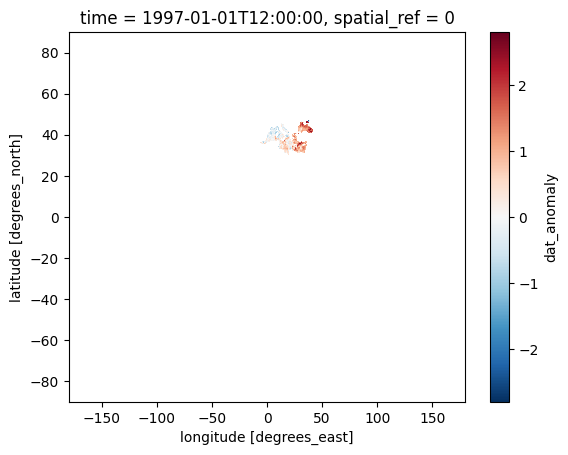

In [8]:
ossta.isel(time=0).where(region_masks_ds['Mediterranean_Sea']).plot()

In [120]:
print(oceans["name"].unique())


['Southern Ocean' 'South Atlantic Ocean' 'South Pacific Ocean'
 'North Pacific Ocean' 'South China and Easter Archipelagic Seas'
 'Indian Ocean' 'Mediterranean Region' 'Baltic Sea' 'North Atlantic Ocean'
 'Arctic Ocean']


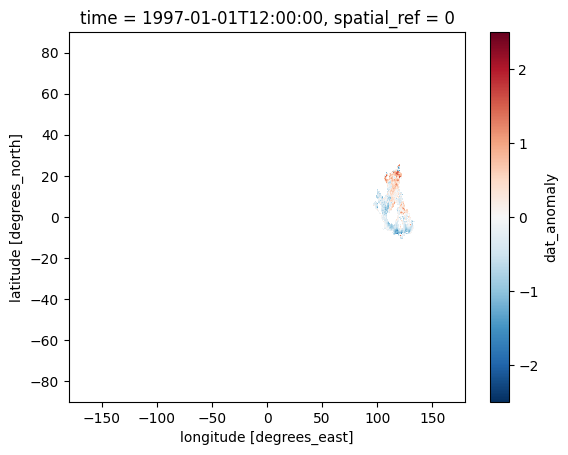

In [126]:
ossta.where(region_masks['South_China_Easter_Archipelagic_Seas']).plot()

In [132]:
list(region_masks)

['North Pacific Ocean_MidSouth',
 'North Pacific Ocean_Equatorial',
 'North Pacific Ocean_MidNorth',
 'North Pacific Ocean_Northern',
 'South Pacific Ocean_MidSouth',
 'South Pacific Ocean_Equatorial',
 'South Pacific Ocean_MidNorth',
 'North Atlantic Ocean_MidSouth',
 'North Atlantic Ocean_Equatorial',
 'North Atlantic Ocean_MidNorth',
 'North Atlantic Ocean_Northern',
 'South Atlantic Ocean_MidSouth',
 'South Atlantic Ocean_Equatorial',
 'South Atlantic Ocean_MidNorth',
 'Indian Ocean_MidSouth',
 'Indian Ocean_Equatorial',
 'Indian Ocean_MidNorth',
 'Indian Ocean_Northern',
 'Southern_Ocean',
 'Mediterranean_Sea',
 'Baltic_Sea',
 'South_China_Easter_Archipelagic_Seas',
 'Pacific_Equatorial',
 'Atlantic_Equatorial',
 'Indian_Equatorial']

/home/b/b382616/.local/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 10.90 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


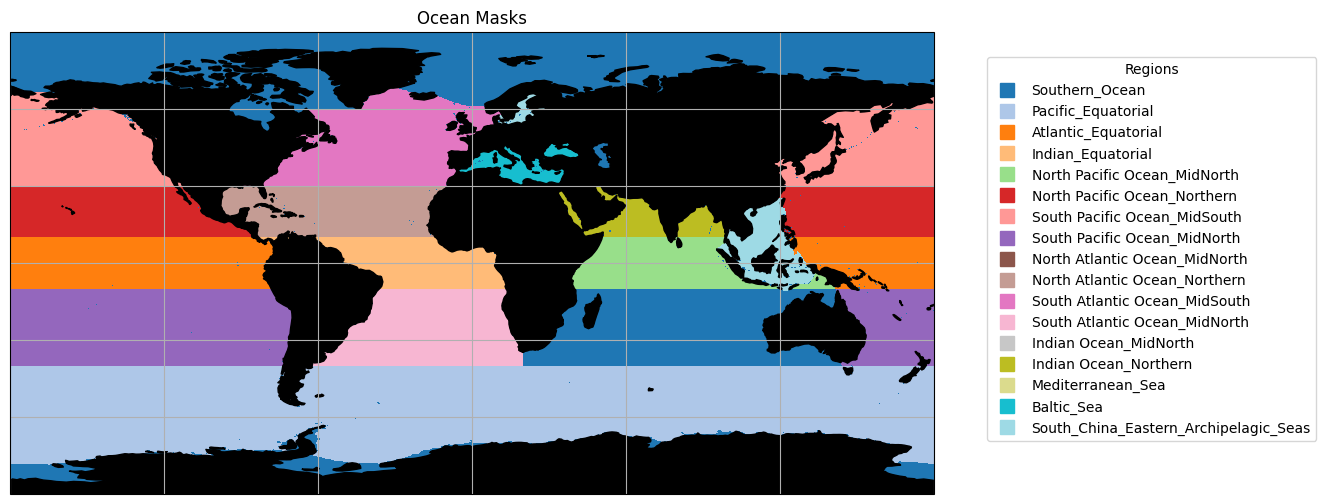

In [136]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors

# 1. Combine all masks into one array of integers
combined = xr.full_like(list(region_masks.values())[0], fill_value=0, dtype=int)

for i, (name, mask) in enumerate(region_masks.items(), start=1):
    combined = combined.where(~mask, other=i)

# 2. Set up colormap and legend
num_regions = len(region_masks)
cmap = plt.get_cmap("tab20", num_regions)
labels = list(region_masks.keys())
norm = mcolors.BoundaryNorm(boundaries=np.arange(0, num_regions+1), ncolors=num_regions)

# 3. Plot with Cartopy
fig, ax = plt.subplots(figsize=(14,6), subplot_kw={'projection': ccrs.PlateCarree()})
im = combined.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# Add coastlines and gridlines
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='black', zorder=2)
ax.gridlines()

# 4. Create legend manually
handles = [plt.Line2D([0], [0], marker='s', color=cmap(i), linestyle='', markersize=10)
           for i in range(num_regions)]
ax.legend(handles, labels, loc='lower left', bbox_to_anchor=(1.05, 0.1), title="Regions")

plt.title("Ocean Masks")
plt.show()
